In [1]:
import geopandas as pd
import contextily as ctx # Used for contextual basemaps
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube # Used for rasterizing
import os
import shapely
import imageio # Used for making animated GIFs
import numpy as np
from IPython.display import Image
from osgeo import gdal # Raster operations
import zipfile
import rasterio
import rasterio.merge
import rasterio.plot
import rasterio.mask
plt.rcParams['figure.figsize'] = (20, 20)
os.listdir("input")

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


['lds-nz-road-centrelines-topo-150k-FGDB.zip',
 'lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip',
 'statsnzpopulation-by-meshblock-2013-census-FGDB.zip',
 'statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip',
 'statsnzregional-council-2021-clipped-generalised-FGDB.zip',
 'lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip']

First, read regional council bounds. This geometry will be used to clip NZ-wide datasets to just the region of interest, Auckland

epsg:2193
CPU times: user 1.92 s, sys: 997 ms, total: 2.92 s
Wall time: 14.6 s


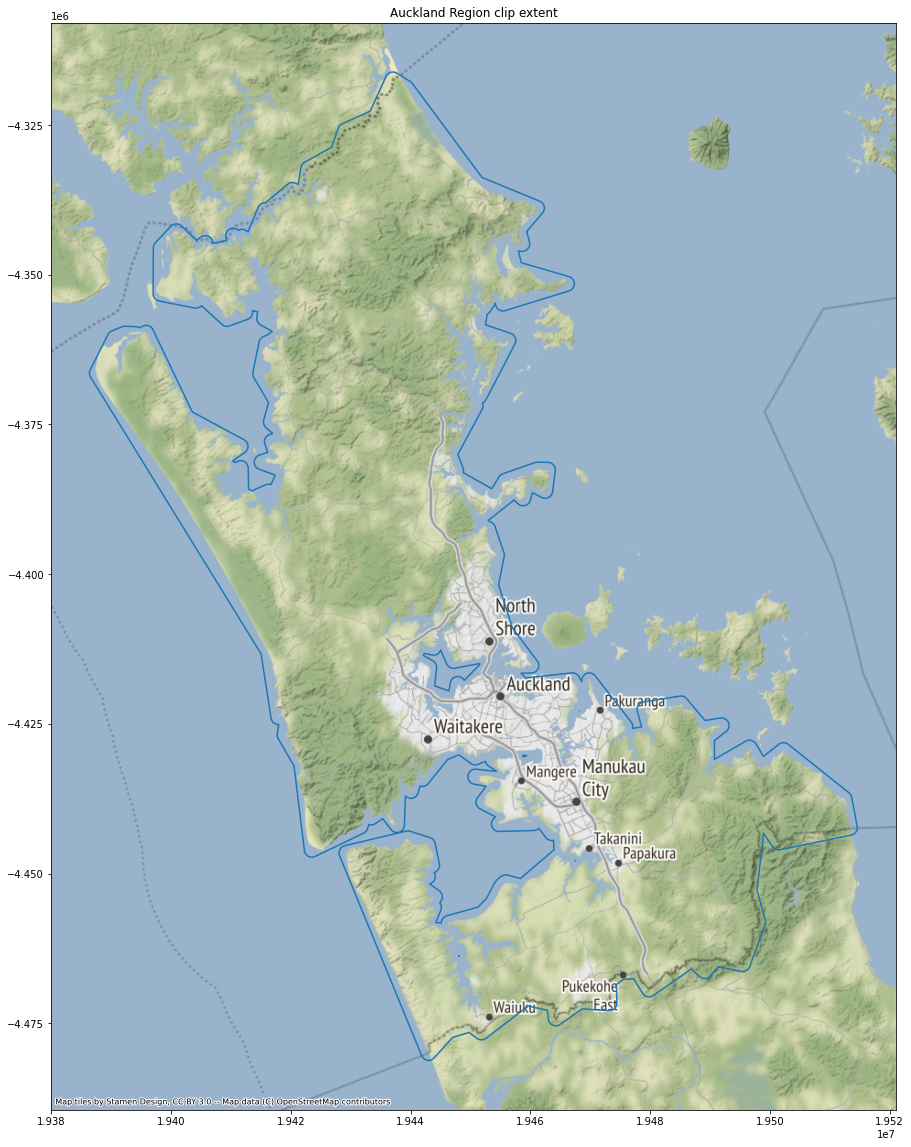

In [2]:
%%time
REGC = pd.read_file("input/statsnzregional-council-2021-clipped-generalised-FGDB.zip!regional-council-2021-clipped-generalised.gdb")
AKL = REGC[REGC.REGC2021_V1_00_NAME == "Auckland Region"].copy()
# Filter out islands
AKL["geometry"] = max(AKL.geometry.explode(), key=lambda a: a.area)
# Coordinate reference system (projection)
print(AKL.crs)
# Simplify geometry to speed up clip operations
AKL = AKL.simplify(1000).buffer(1000)
ax = AKL.to_crs(epsg=3857).boundary.plot()
ax.set_title("Auckland Region clip extent")
ctx.add_basemap(ax)

## Land use
Load the LRIS Land Cover Database (downloaded in GDB format from https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/)

In [3]:
%%time
df = pd.read_file("zip://input/lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip!lcdb-v50-land-cover-database-version-50-mainland-new-zealand.gdb")

CPU times: user 1min 46s, sys: 2.2 s, total: 1min 48s
Wall time: 1min 48s


In [4]:
print(df.columns)
print(df.crs)
display(df.sample(5))

Index(['Name_2018', 'Name_2012', 'Name_2008', 'Name_2001', 'Name_1996',
       'Class_2018', 'Class_2012', 'Class_2008', 'Class_2001', 'Class_1996',
       'Wetland_18', 'Wetland_12', 'Wetland_08', 'Wetland_01', 'Wetland_96',
       'Onshore_18', 'Onshore_12', 'Onshore_08', 'Onshore_01', 'Onshore_96',
       'EditAuthor', 'EditDate', 'LCDB_UID', 'geometry'],
      dtype='object')
epsg:2193


Name_2018               Name_2012  \
456588      Forest - Harvested           Exotic Forest   
70794        Indigenous Forest       Indigenous Forest   
477868    Manuka and/or Kanuka    Manuka and/or Kanuka   
95291        Indigenous Forest       Indigenous Forest   
91925   Mixed Exotic Shrubland  Mixed Exotic Shrubland   

                     Name_2008               Name_2001  \
456588           Exotic Forest           Exotic Forest   
70794        Indigenous Forest       Indigenous Forest   
477868    Manuka and/or Kanuka    Manuka and/or Kanuka   
95291        Indigenous Forest       Indigenous Forest   
91925   Mixed Exotic Shrubland  Mixed Exotic Shrubland   

                     Name_1996  Class_2018  Class_2012  Class_2008  \
456588           Exotic Forest          64          71          71   
70794        Indigenous Forest          69          69          69   
477868    Manuka and/or Kanuka          52          52          52   
95291        Indigenous Forest          69          69          69   
91925   Mixed Exotic Shrubland          56          56          56   

        Class_2001  Class_1996  ... Wetland_96 Onshore_18 Onshore_12  \
456588          71          71  ...         no        yes        yes   
70794           69          69  ...         no        yes        yes   
477868          52          52  ...         no        yes        yes   
95291           69          69  ...         no        yes        yes   
91925           56          56  ...         no        yes        yes   

       Onshore_08 Onshore_01 Onshore_96         EditAuthor  \
456588        yes        yes        yes  Landcare Research   
70794         yes        yes        yes          Terralink   
477868        yes        yes        yes  Landcare Research   
95291         yes        yes        yes  Landcare Research   
91925         yes        yes        yes  Landcare Research   

                   EditDate        LCDB_UID  \
456588  2019-12-01T00:00:00  lcdb1000204673   
70794   2004-06-30T00:00:00  lcdb1000149555   
477868  2011-06-30T00:00:00  lcdb2000129365   
95291   2004-06-30T00:00:00  lcdb1000164854   
91925   2004-06-30T00:00:00  lcdb2000161241   

                                                 geometry  
456588  MULTIPOLYGON (((1913804.674 5640128.379, 19137...  
70794   MULTIPOLYGON (((1805863.761 5668182.361, 18058...  
477868  MULTIPOLYGON (((1562023.736 5263331.640, 15620...  
95291   MULTIPOLYGON (((1750564.567 5911475.274, 17505...  
91925   MULTIPOLYGON (((1313320.424 5061848.009, 13133...  

[5 rows x 24 columns]

In [5]:
%%time
df = pd.clip(df, AKL)

CPU times: user 46.2 s, sys: 8.87 ms, total: 46.2 s
Wall time: 46.2 s


In [6]:
df.sample(5)

Name_2018                        Name_2012  \
472502                    Exotic Forest                    Exotic Forest   
182981  High Producing Exotic Grassland  High Producing Exotic Grassland   
465518                Indigenous Forest                Indigenous Forest   
102217       Built-up Area (settlement)       Built-up Area (settlement)   
410578             Manuka and/or Kanuka             Manuka and/or Kanuka   

                         Name_2008                   Name_2001  \
472502               Exotic Forest               Exotic Forest   
182981               Exotic Forest               Exotic Forest   
465518           Indigenous Forest           Indigenous Forest   
102217  Built-up Area (settlement)  Built-up Area (settlement)   
410578        Manuka and/or Kanuka        Manuka and/or Kanuka   

                              Name_1996  Class_2018  Class_2012  Class_2008  \
472502                    Exotic Forest          71          71          71   
182981               Forest - Harvested          40          40          71   
465518                Indigenous Forest          69          69          69   
102217  High Producing Exotic Grassland           1           1           1   
410578             Manuka and/or Kanuka          52          52          52   

        Class_2001  Class_1996  ... Wetland_96 Onshore_18 Onshore_12  \
472502          71          71  ...         no        yes        yes   
182981          71          64  ...         no        yes        yes   
465518          69          69  ...         no        yes        yes   
102217           1          40  ...         no        yes        yes   
410578          52          52  ...         no        yes        yes   

       Onshore_08 Onshore_01 Onshore_96         EditAuthor  \
472502        yes        yes        yes          Terralink   
182981        yes        yes        yes  Landcare Research   
465518        yes        yes        yes          Terralink   
102217        yes        yes        yes  Landcare Research   
410578        yes        yes        yes  Landcare Research   

                   EditDate        LCDB_UID  \
472502  2004-06-30T00:00:00  lcdb1000220842   
182981  2019-12-01T00:00:00  lcdb1000404867   
465518  2004-06-30T00:00:00  lcdb1000164419   
102217  2019-12-01T00:00:00  lcdb1000029055   
410578  2015-06-30T00:00:00  lcdb1000459823   

                                                 geometry  
472502  POLYGON ((1741740.798 5995549.924, 1741729.225...  
182981  POLYGON ((1737493.274 5938844.155, 1737523.779...  
465518  POLYGON ((1775498.312 5901402.556, 1775482.618...  
102217  POLYGON ((1759076.894 5903791.065, 1759113.093...  
410578  POLYGON ((1750481.856 5965190.852, 1750448.371...  

[5 rows x 24 columns]

In [7]:
df.Name_2018.value_counts()

Exotic Forest                                3981
Indigenous Forest                            3673
Manuka and/or Kanuka                         2282
Broadleaved Indigenous Hardwoods             1788
Built-up Area (settlement)                   1350
High Producing Exotic Grassland              1326
Mangrove                                     1151
Urban Parkland/Open Space                    1099
Estuarine Open Water                          441
Orchard, Vineyard or Other Perennial Crop     436
Short-rotation Cropland                       362
Lake or Pond                                  326
Herbaceous Saline Vegetation                  303
Low Producing Grassland                       291
Gorse and/or Broom                            287
Forest - Harvested                            266
Sand or Gravel                                252
Deciduous Hardwoods                           201
Surface Mine or Dump                          132
Mixed Exotic Shrubland                        120


These classes are far too detailed - simplify to just Urban, Vegetation, Water, Other

In [8]:
def simplify_classes(code):
    if code in [1, 2, 5]:
        return 1, "Urban"
    elif code in [68,69,71]:
        return 2, "Vegetation"
    elif code in [0,20,21,22,45,46]:
        return 3, "Water"
    else:
        return 4, "Other"

summary = []
years = [1996, 2001, 2008, 2012, 2018]
for year in years:
    print(year)
    class_year = f"Class_{year}"
    df[class_year + "_simplified_code"] = df[class_year].apply(lambda c: simplify_classes(c)[0])
    df[class_year + "_simplified_name"] = df[class_year].apply(lambda c: simplify_classes(c)[1])
    summary.append(df[class_year + "_simplified_name"].value_counts())

1996
2001
2008
2012
2018


<AxesSubplot:>

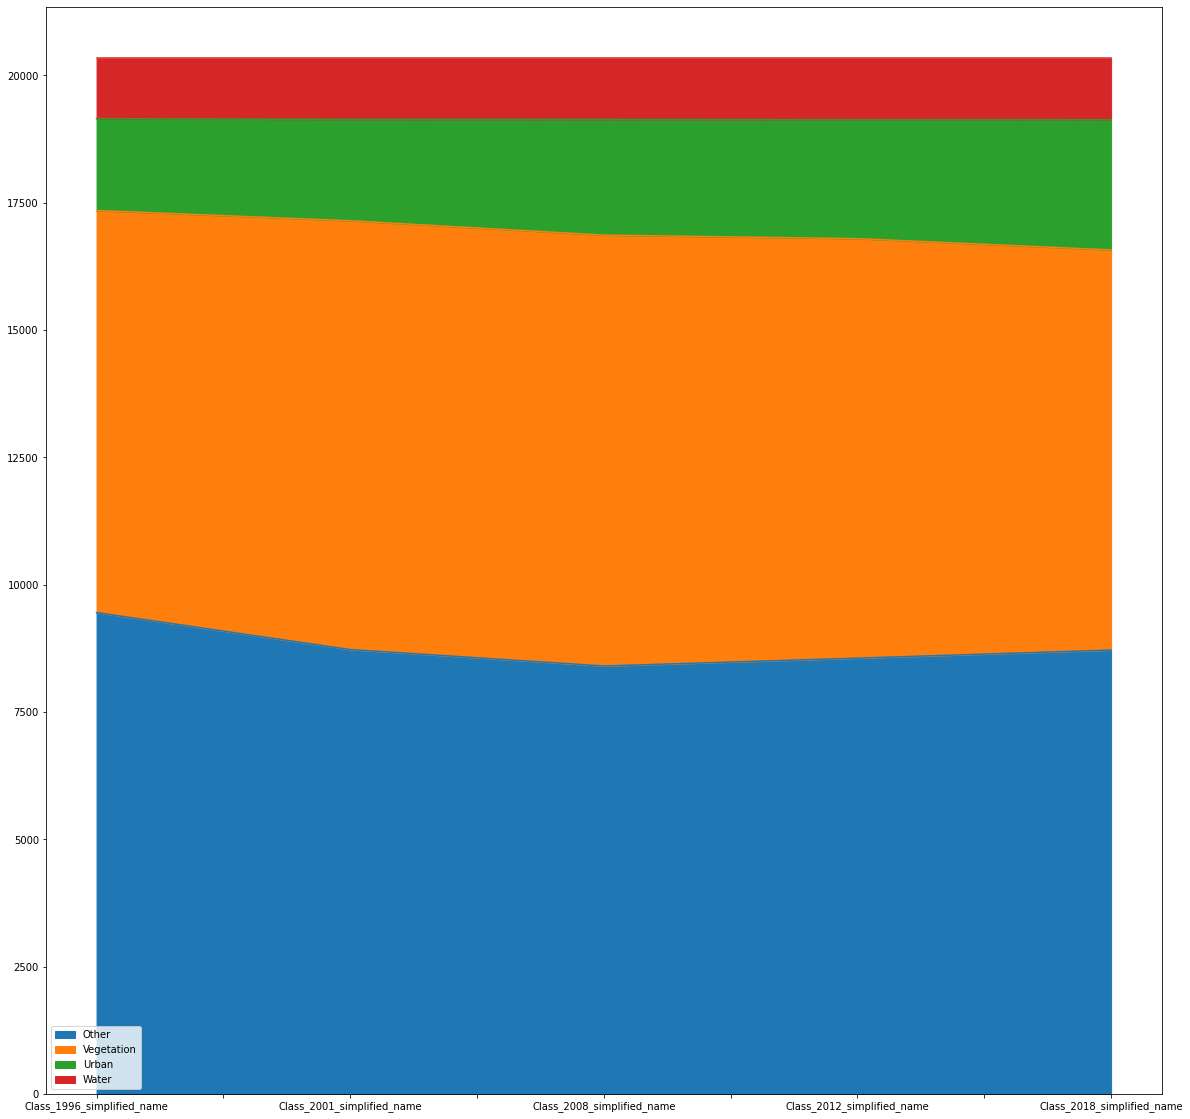

In [9]:
pd.GeoDataFrame(summary).plot.area()

In [10]:
%%capture
# %%capture suppresses output
ims = []
years = [1996, 2001, 2008, 2012, 2018]
for year in years:
    ax = df.plot(column=f'Class_{year}_simplified_name', legend=True)
    ax.set_title(year)
    ax.figure.tight_layout()
    canvas = ax.figure.canvas
    canvas.draw() # draw the canvas, cache the renderer
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (3,))
    ims.append(image)

imageio.mimsave("land_use.gif", ims, fps=1)

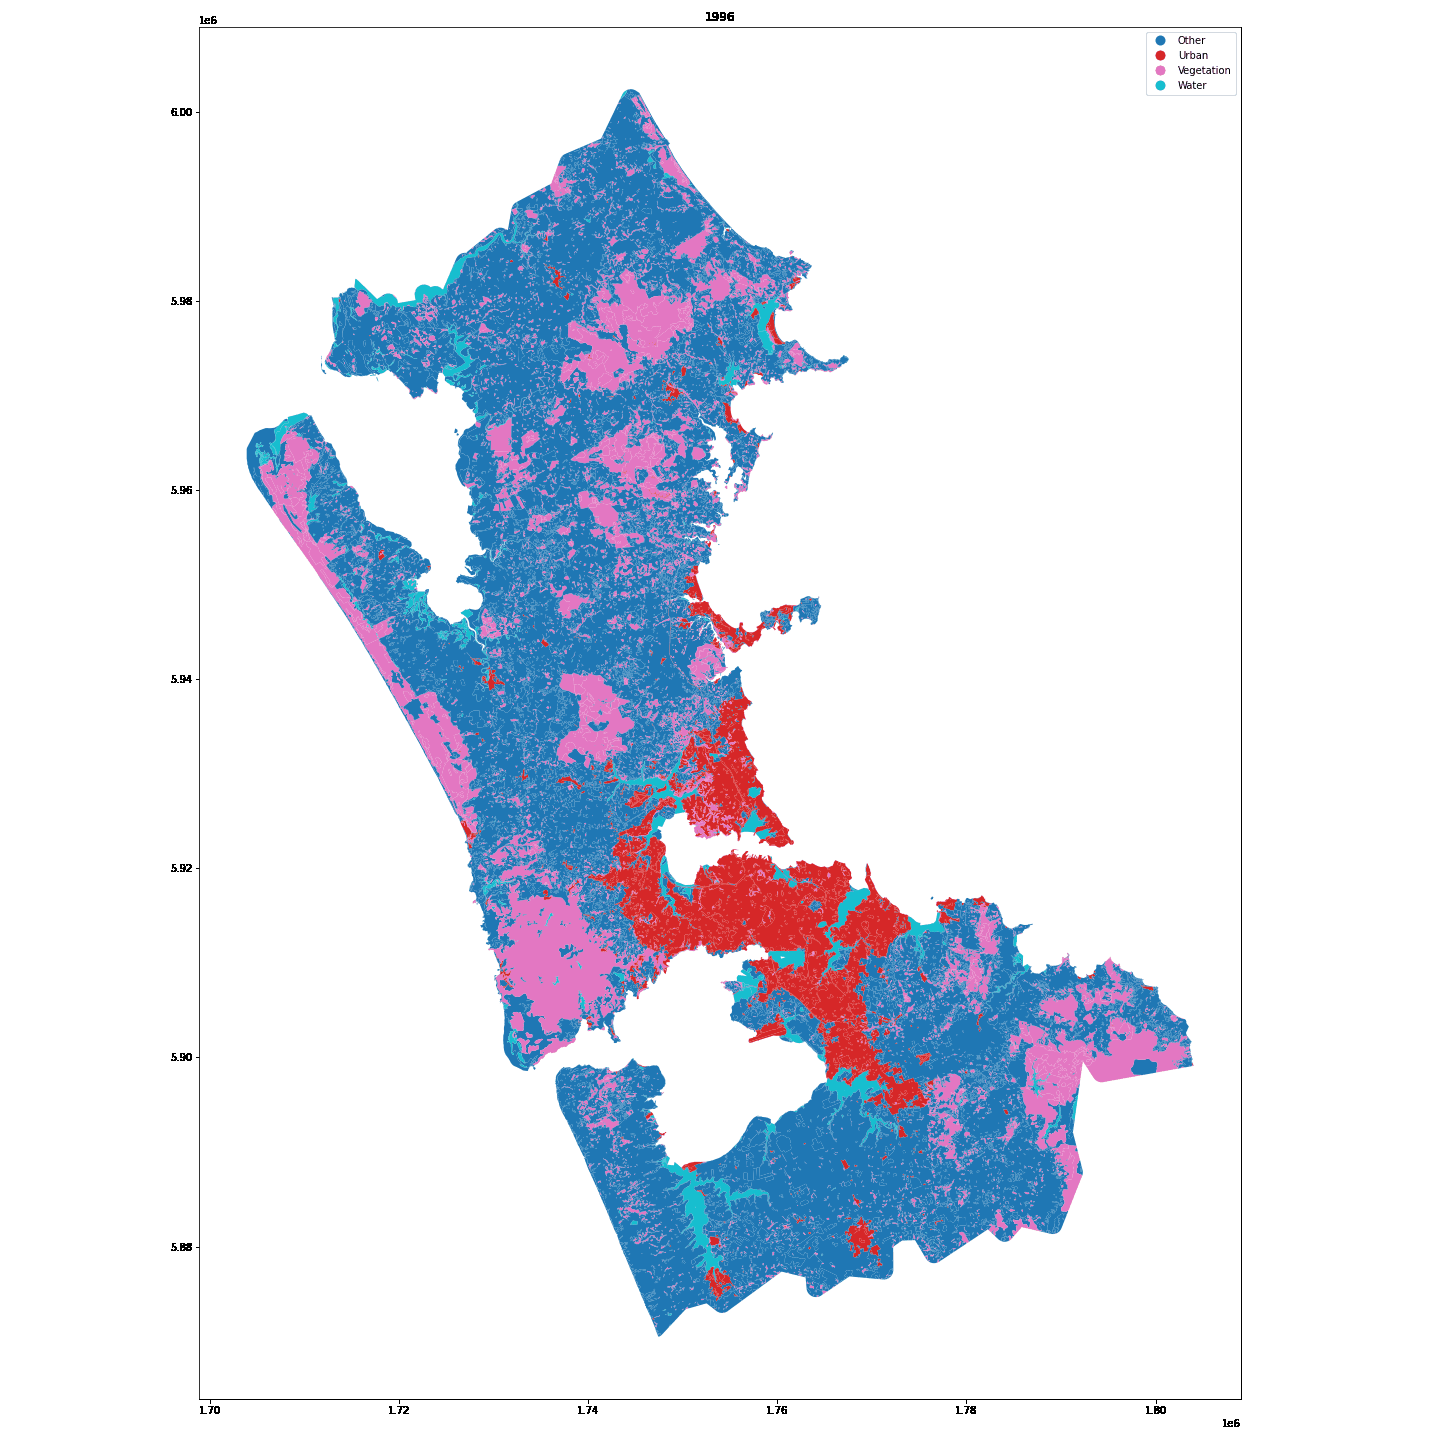

In [11]:
with open('land_use.gif','rb') as file:
    display(Image(file.read()))

In [12]:
cols = [f"Class_{year}_simplified_code" for year in years]
cols

['Class_1996_simplified_code',
 'Class_2001_simplified_code',
 'Class_2008_simplified_code',
 'Class_2012_simplified_code',
 'Class_2018_simplified_code']

In [13]:
%%time
geocube = make_geocube(
    vector_data=df,
    output_crs="epsg:2193",
    measurements=cols,
    resolution=(-100, 100),
    fill=0, # NaNs, like offshore areas, will be 0
)
geocube

CPU times: user 20.3 s, sys: 0 ns, total: 20.3 s
Wall time: 20.3 s


<xarray.Dataset>
Dimensions:                     (x: 1001, y: 1320)
Coordinates:
  * y                           (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                           (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                 int64 0
Data variables:
    Class_1996_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2001_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2008_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2012_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2018_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

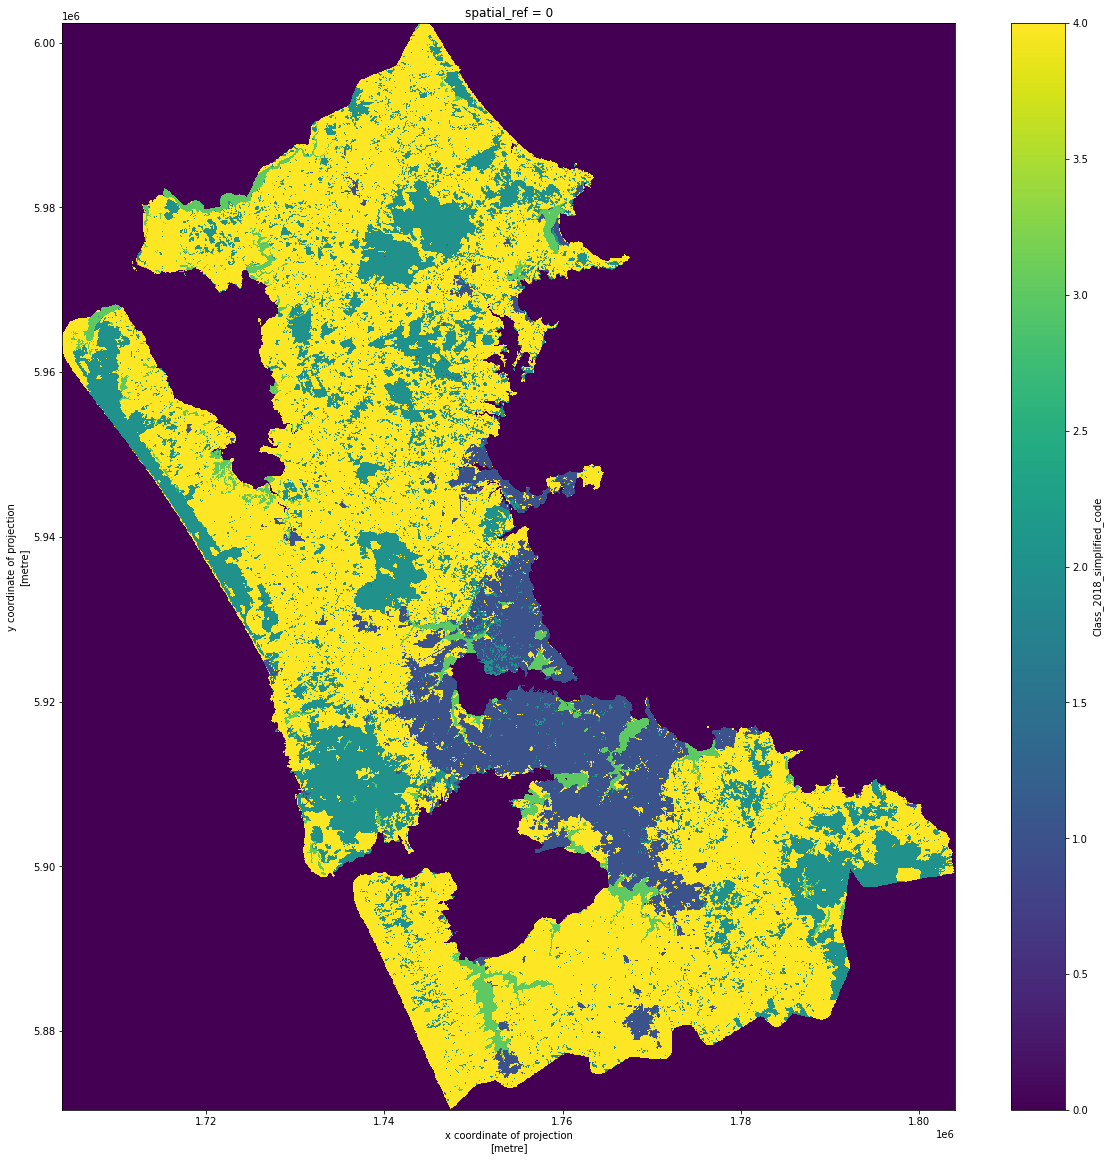

In [14]:
geocube.Class_2018_simplified_code.plot()

In [15]:
for year in years:
    print(year)
    outfile = f"output/land_use_{year}.tif"
    if not os.path.isfile(outfile):
        geocube[f"Class_{year}_simplified_code"].rio.to_raster(outfile, dtype=np.byte) # Use np.byte for smaller output filesize

1996
2001
2008
2012
2018


## Population density

In [16]:
%%time
pop2013 = pd.read_file("input/statsnzpopulation-by-meshblock-2013-census-FGDB.zip!population-by-meshblock-2013-census.gdb")

CPU times: user 9.43 s, sys: 39.9 ms, total: 9.47 s
Wall time: 9.46 s


In [17]:
%%time
pop2013 = pd.clip(pop2013, AKL)

CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 19.2 s


In [18]:
display(pop2013.sample(5))

Meshblock MeshblockNumber  Population_Count_Usual_Resident_2013  \
16475  MB 0566500         0566500                                   189   
18533  MB 0712038         0712038                                    84   
11124  MB 0174215         0174215                                    45   
12240  MB 0359800         0359800                                    48   
19078  MB 0736602         0736602                                    72   

       Population_Count_Census_Night_2013  \
16475                                 186   
18533                                  84   
11124                                  45   
12240                                  48   
19078                                  78   

                                                geometry  
16475  POLYGON ((1757996.163 5914365.449, 1758017.262...  
18533  POLYGON ((1770998.139 5909579.009, 1770979.684...  
11124  POLYGON ((1756417.123 5944333.279, 1756401.224...  
12240  POLYGON ((1755475.931 5924071.204, 1755453.408...  
19078  POLYGON ((1761138.453 5907675.610, 1761141.570...

In [19]:
#pop2013.Population_Count_Usual_Resident_2013.replace(0, np.nan, inplace=True)

<AxesSubplot:ylabel='Frequency'>

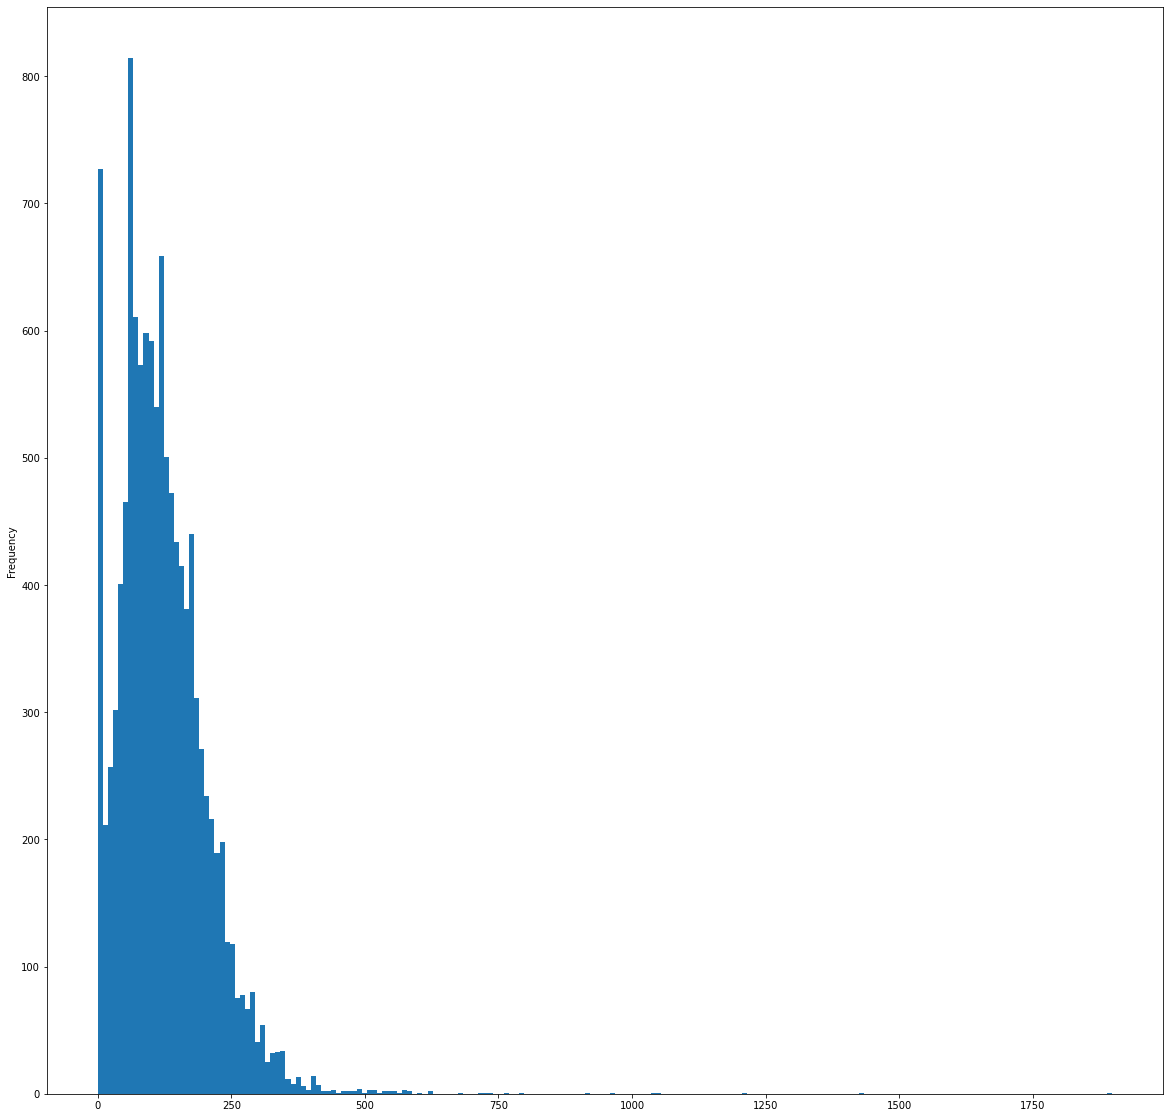

In [20]:
pop2013.Population_Count_Usual_Resident_2013.plot(kind="hist", bins=200)

In [21]:
%%time
pop2013_cube = make_geocube(
    vector_data=pop2013,
    measurements=["Population_Count_Usual_Resident_2013"],
    like=geocube, # Ensures dimensions match
    fill=0 # NaNs, like offshore areas, will be 0
)
pop2013_cube

CPU times: user 2.82 s, sys: 19.7 ms, total: 2.84 s
Wall time: 2.84 s


<xarray.Dataset>
Dimensions:                               (x: 1001, y: 1320)
Coordinates:
  * y                                     (y) float64 6.002e+06 ... 5.87e+06
  * x                                     (x) float64 1.704e+06 ... 1.804e+06
    spatial_ref                           int64 0
Data variables:
    Population_Count_Usual_Resident_2013  (y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

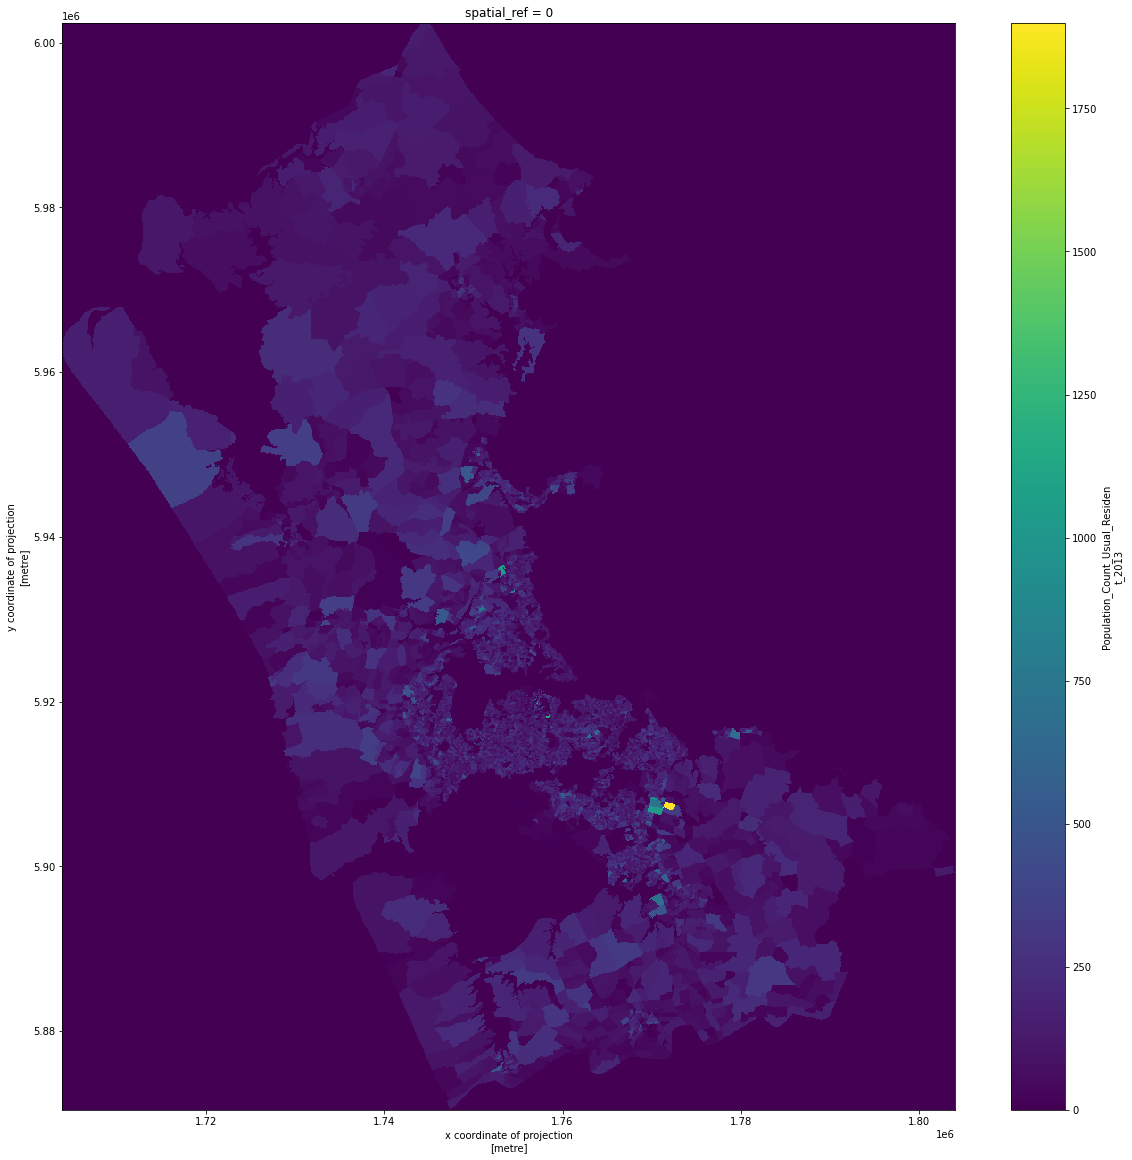

In [22]:
pop2013_cube.Population_Count_Usual_Resident_2013.plot()
outfile = "output/pop2013.tif"
if not os.path.isfile(outfile):
    # byte max value is 255, and we have larger values than that here. uint16 max value is 65535, which is fine
    pop2013_cube.Population_Count_Usual_Resident_2013.rio.to_raster(outfile, dtype=np.uint16)

In [23]:
%%time
pop2018 = pd.read_file("input/statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip!2018-census-electoral-population-meshblock-2020.gdb")

CPU times: user 11.1 s, sys: 60 ms, total: 11.1 s
Wall time: 11.1 s


In [24]:
%%time
pop2018 = pd.clip(pop2018, AKL)

CPU times: user 23.4 s, sys: 0 ns, total: 23.4 s
Wall time: 23.4 s


In [25]:
display(pop2018.sample(5))

MB2020_V2_00  General_Electoral_Population  Maori_Electoral_Population  \
13510      0247200                            78                          12   
19198      0773901                           174                          45   
679        0147208                          -999                        -999   
18259      0712227                            30                        -999   
17261      0634700                            81                          15   

      GED2020_V1_00 GED2020_V1_00_NAME GED2020_V1_00_NAME_ASCII MED2020_V1_00  \
13510           053           Te Atatū                 Te Atatu             5   
19198           022           Manurewa                 Manurewa             3   
679             063       Whangaparāoa             Whangaparaoa             5   
18259           048           Takanini                 Takanini             3   
17261           037    Panmure-Ōtāhuhu          Panmure-Otahuhu             3   

      MED2020_V1_00_NAME MED2020_V1_00_NAME_ASCII  LAND_AREA_SQ_KM  \
13510     Te Tai Tokerau           Te Tai Tokerau         0.112647   
19198    Tāmaki Makaurau          Tamaki Makaurau         0.091352   
679       Te Tai Tokerau           Te Tai Tokerau         0.000000   
18259    Tāmaki Makaurau          Tamaki Makaurau         0.829417   
17261    Tāmaki Makaurau          Tamaki Makaurau         0.025023   

       AREA_SQ_KM  Shape_Length  \
13510    0.112647   1561.853529   
19198    0.091352   1252.159831   
679      2.829588  33620.211188   
18259    0.829417   4631.512562   
17261    0.025023    632.166140   

                                                geometry  
13510  POLYGON ((1746533.933 5921949.716, 1746541.847...  
19198  POLYGON ((1765387.586 5898586.734, 1765523.502...  
679    POLYGON ((1751700.492 5946715.065, 1751700.562...  
18259  POLYGON ((1772526.177 5908864.533, 1772552.511...  
17261  POLYGON ((1765735.390 5911895.910, 1765737.404...

In [26]:
pop2018.General_Electoral_Population.replace(-999, 0, inplace=True)

<AxesSubplot:ylabel='Frequency'>

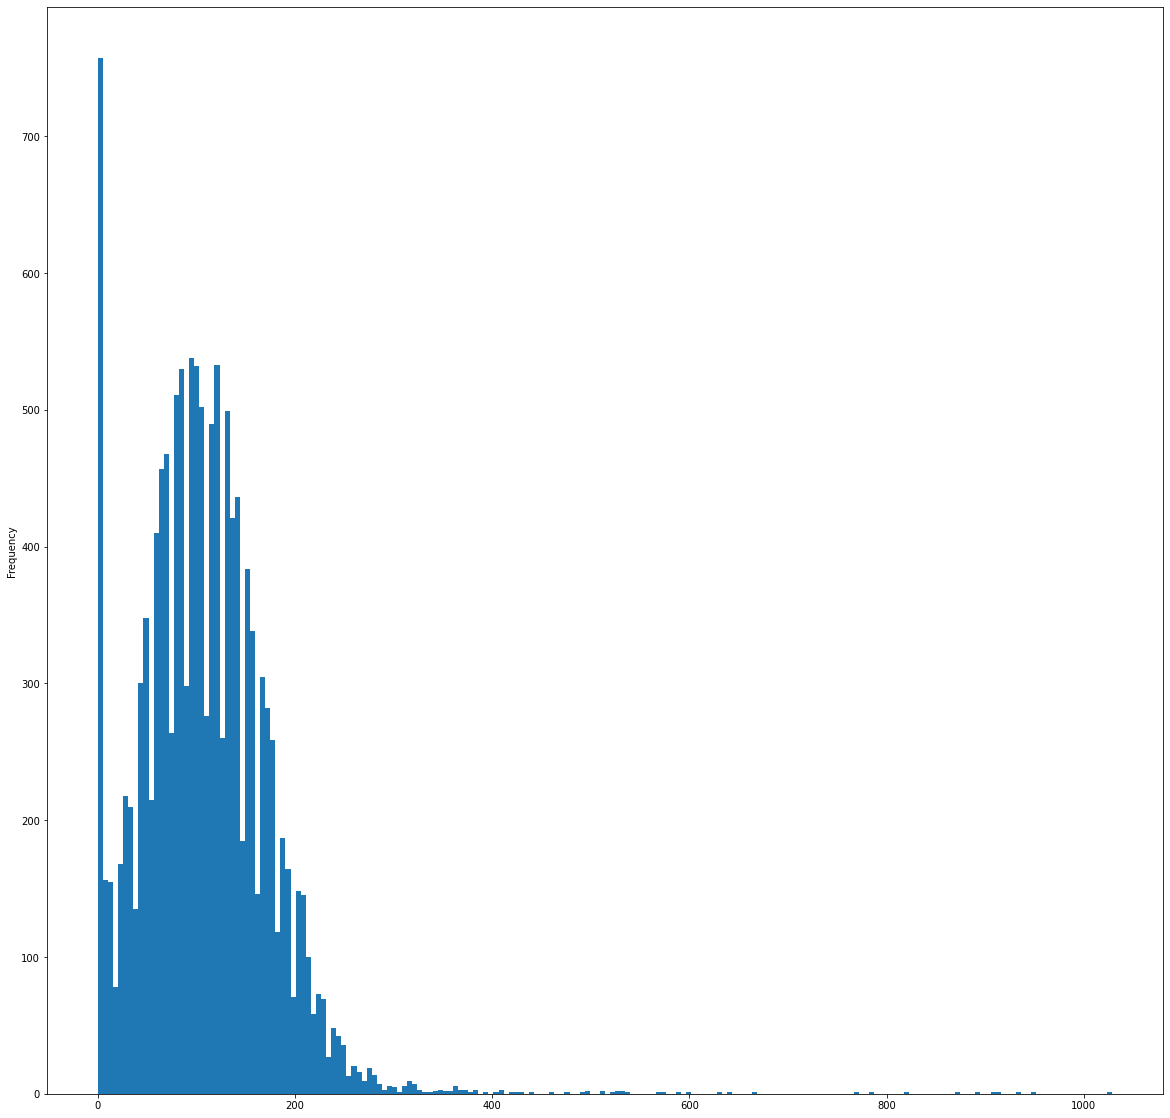

In [27]:
pop2018.General_Electoral_Population.plot(kind="hist", bins=200)

In [28]:
%%time
pop2018_cube = make_geocube(
    vector_data=pop2018,
    measurements=["General_Electoral_Population"],
    like=geocube, # Ensures dimensions match
    fill=0
)
pop2018_cube

CPU times: user 2.51 s, sys: 205 µs, total: 2.51 s
Wall time: 2.51 s


<xarray.Dataset>
Dimensions:                       (x: 1001, y: 1320)
Coordinates:
  * y                             (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                             (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                   int64 0
Data variables:
    General_Electoral_Population  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

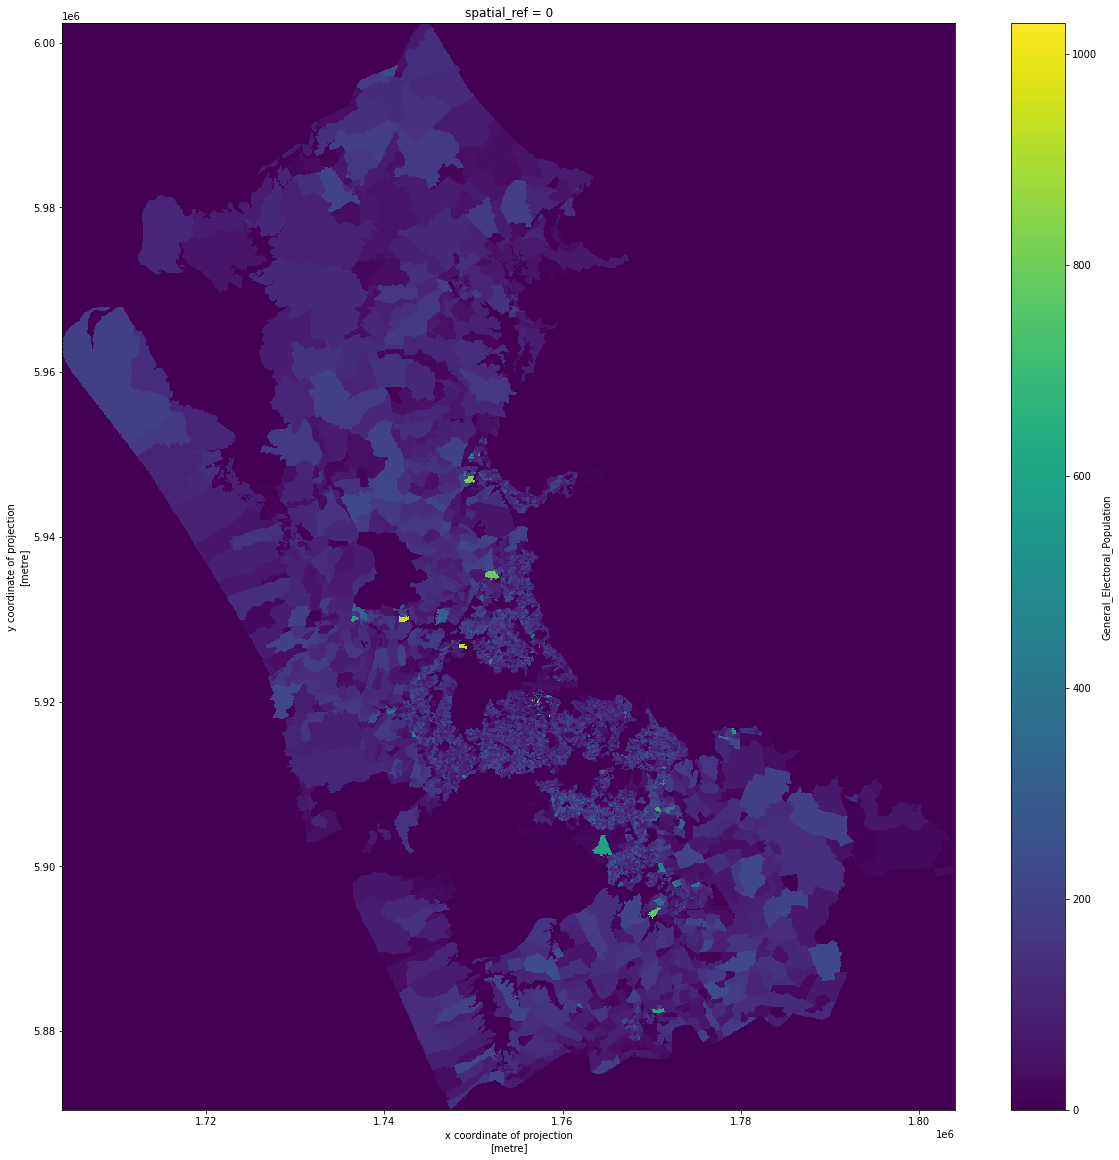

In [29]:
pop2018_cube.General_Electoral_Population.plot()
outfile = "output/pop2018.tif"
if not os.path.isfile(outfile):
    pop2018_cube.General_Electoral_Population.rio.to_raster(outfile, dtype=np.uint16)

## Distance from major roads

In [30]:
%%time
roads = pd.read_file("input/lds-nz-road-centrelines-topo-150k-FGDB.zip!nz-road-centrelines-topo-150k.gdb")

CPU times: user 12 s, sys: 20.1 ms, total: 12 s
Wall time: 12 s


In [31]:
%%time
akl_roads = pd.clip(roads, AKL)

CPU times: user 23.1 s, sys: 0 ns, total: 23.1 s
Wall time: 23.1 s


In [32]:
# If a road has a highway number (hway_num not None), it's a highway/motorway
mway = akl_roads[~akl_roads.hway_num.isna()].copy()
mway

t50_fid                  name_ascii macronated  \
512     100120610       KAIPARA COAST HIGHWAY          N   
2933      3198057             STATE HIGHWAY 1          N   
2934      3198059             STATE HIGHWAY 1          N   
3320      3200754                PAERATA ROAD          N   
3324      3200792      UPPER HARBOUR MOTORWAY          N   
...           ...                         ...        ...   
138240  100048291   AUCKLAND-WAIWERA MOTORWAY          N   
138301  100048432  AUCKLAND-HAMILTON MOTORWAY          N   
138337  100048532             STATE HIGHWAY 1          N   
138369  100048589            PORT ALBERT ROAD          N   
138680  100118365      SOUTH-WESTERN MOTORWAY          N   

                              name hway_num  rna_sufi  lane_count way_count  \
512          KAIPARA COAST HIGHWAY       16   3007739           2      None   
2933               STATE HIGHWAY 1        1   3027695           2      None   
2934               STATE HIGHWAY 1        1   3027695           2      None   
3320                  PAERATA ROAD       22   3000260           2      None   
3324        UPPER HARBOUR MOTORWAY       18   3047073           4      None   
...                            ...      ...       ...         ...       ...   
138240   AUCKLAND-WAIWERA MOTORWAY        1   3067966           7      None   
138301  AUCKLAND-HAMILTON MOTORWAY        1   3017109           1      None   
138337             STATE HIGHWAY 1        1   3027695           4      None   
138369            PORT ALBERT ROAD       16   3013274           2      None   
138680      SOUTH-WESTERN MOTORWAY       20   3018532           4      None   

       status surface                                           geometry  
512      None  sealed  LINESTRING (1732000.000 5944172.070, 1732048.5...  
2933     None  sealed  LINESTRING (1748581.508 5968975.145, 1748558.4...  
2934     None  sealed  LINESTRING (1748171.047 5971284.152, 1748129.9...  
3320     None  sealed  LINESTRING (1767236.112 5888088.508, 1767244.3...  
3324     None  sealed  LINESTRING (1747954.314 5927269.837, 1747970.0...  
...       ...     ...                                                ...  
138240   None  sealed  LINESTRING (1755881.018 5922863.734, 1755886.4...  
138301   None  sealed  LINESTRING (1765115.647 5909916.697, 1765092.7...  
138337   None  sealed  LINESTRING (1748892.089 5949596.727, 1748892.0...  
138369   None  sealed  LINESTRING (1734173.019 5980575.187, 1734175.6...  
138680   None  sealed  LINESTRING (1760066.252 5908184.133, 1760043.9...  

[426 rows x 11 columns]

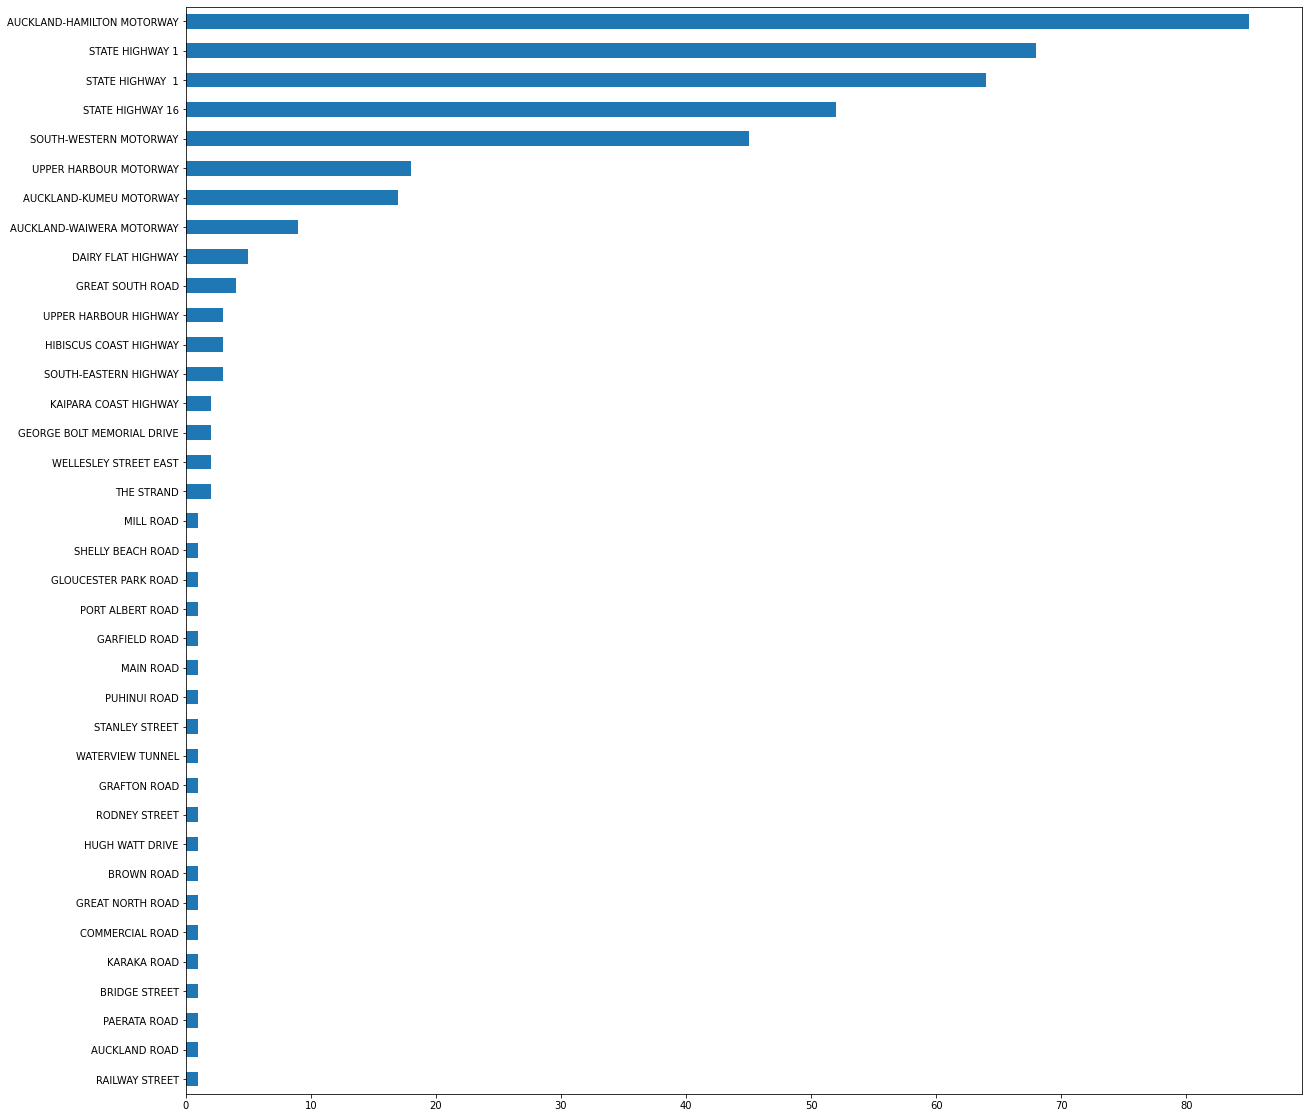

In [33]:
mway.name.value_counts().head(50).plot(kind="barh").invert_yaxis()

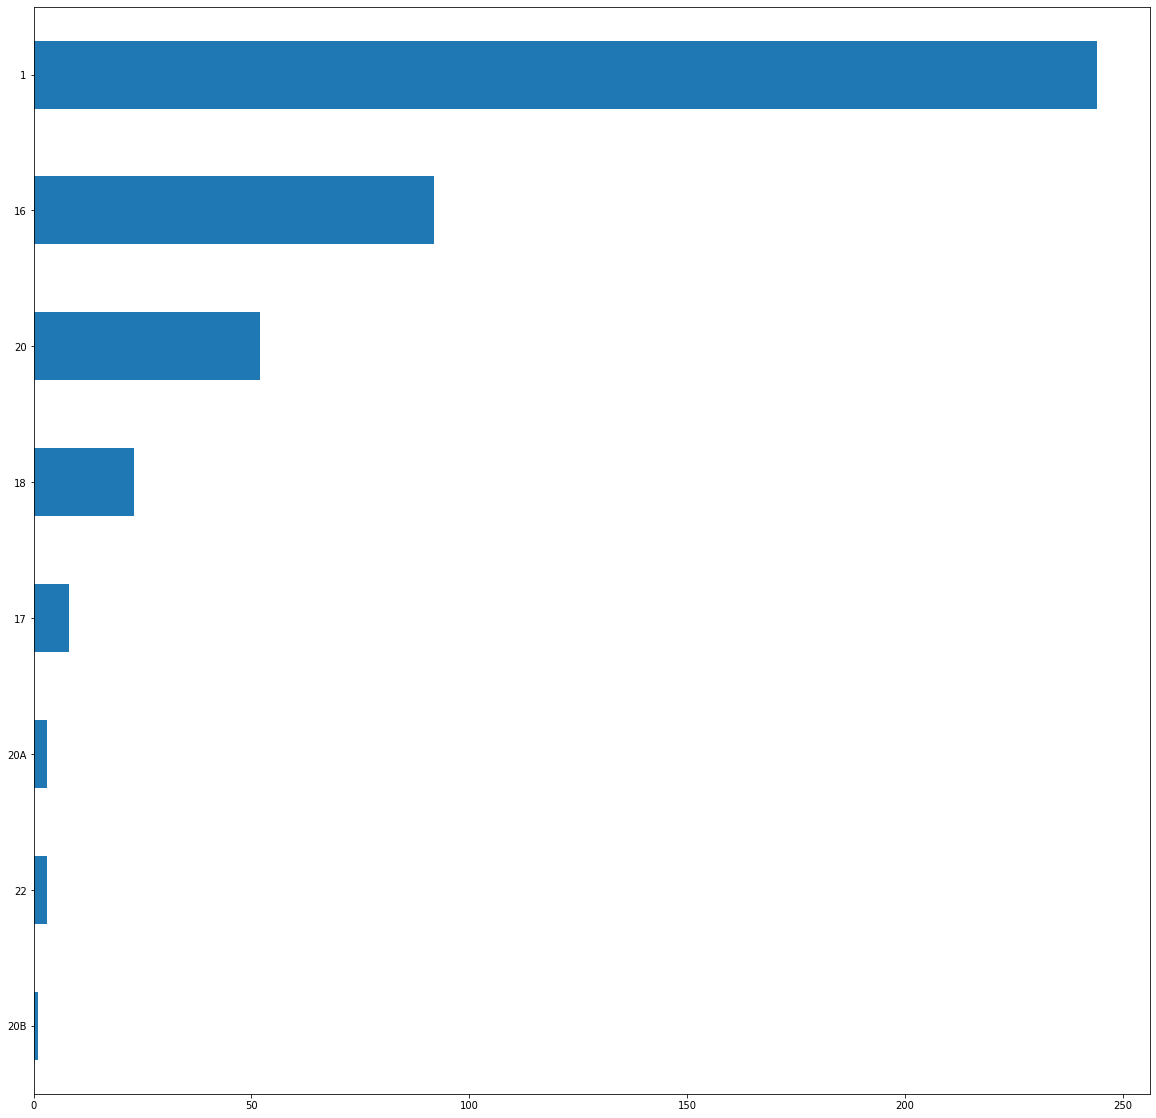

In [34]:
mway.hway_num.value_counts().head(50).plot(kind="barh").invert_yaxis()

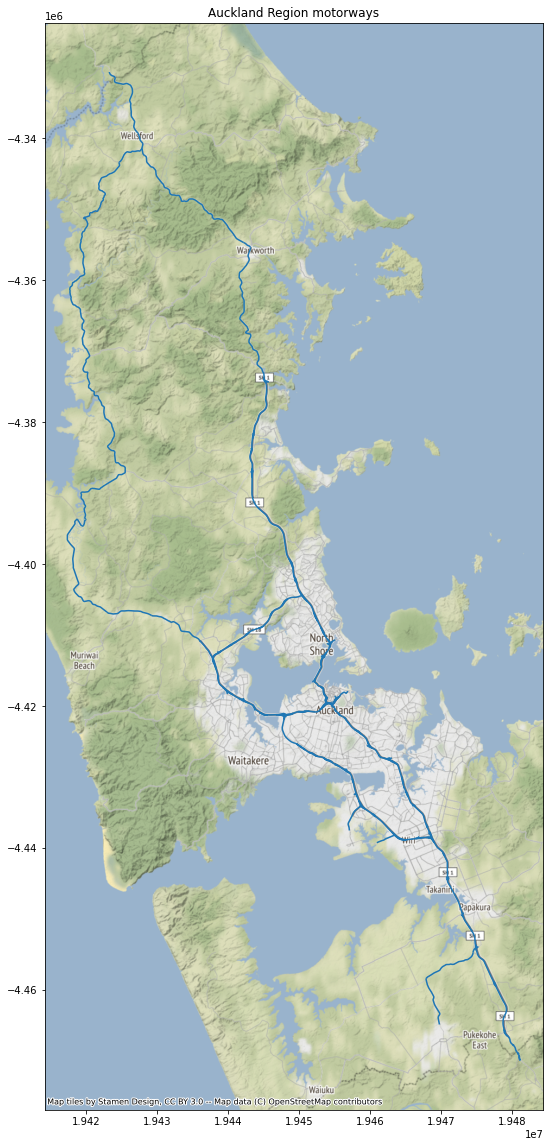

In [35]:
ax = mway.to_crs(epsg=3857).plot()
ax.set_title("Auckland Region motorways")
ctx.add_basemap(ax)

In [36]:
%%time
mway_cube = make_geocube(
    vector_data=mway,
    measurements=["lane_count"],
    like=geocube, # Ensures dimensions match
    fill=0, # 0 works fine here, as every mway has at least one lane
)
mway_cube

CPU times: user 232 ms, sys: 41 µs, total: 232 ms
Wall time: 230 ms


<xarray.Dataset>
Dimensions:      (x: 1001, y: 1320)
Coordinates:
  * y            (y) float64 6.002e+06 6.002e+06 ... 5.871e+06 5.87e+06
  * x            (x) float64 1.704e+06 1.704e+06 ... 1.804e+06 1.804e+06
    spatial_ref  int64 0
Data variables:
    lane_count   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

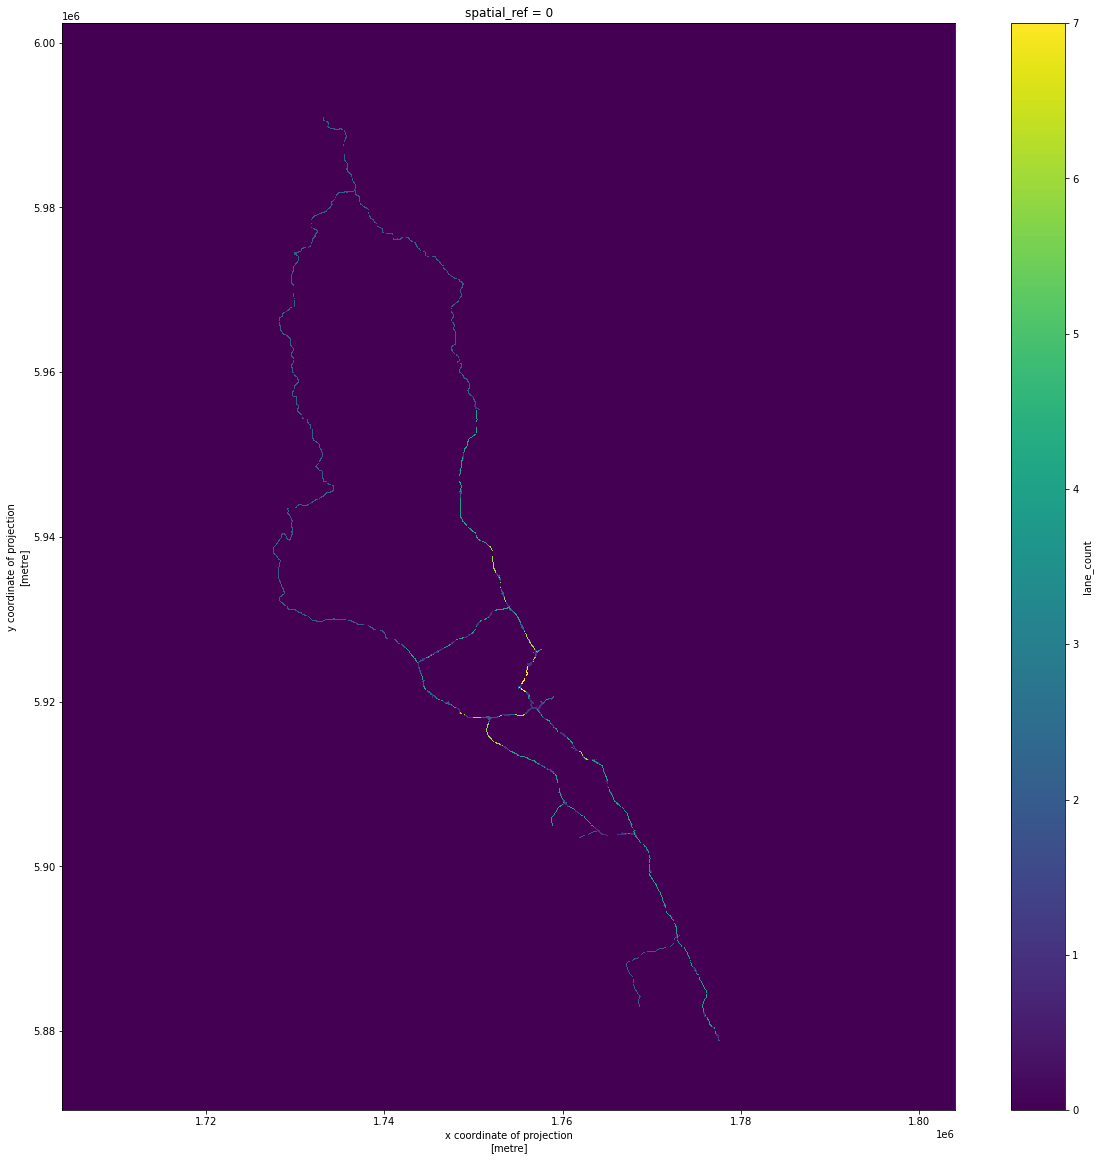

In [37]:
mway_cube.lane_count.plot()
outfile = "output/mway.tif"
if not os.path.isfile(outfile):
    mway_cube.lane_count.rio.to_raster(outfile, dtype=np.byte)

(1320, 1001)


Text(0.5, 1.0, 'Distance (m)')

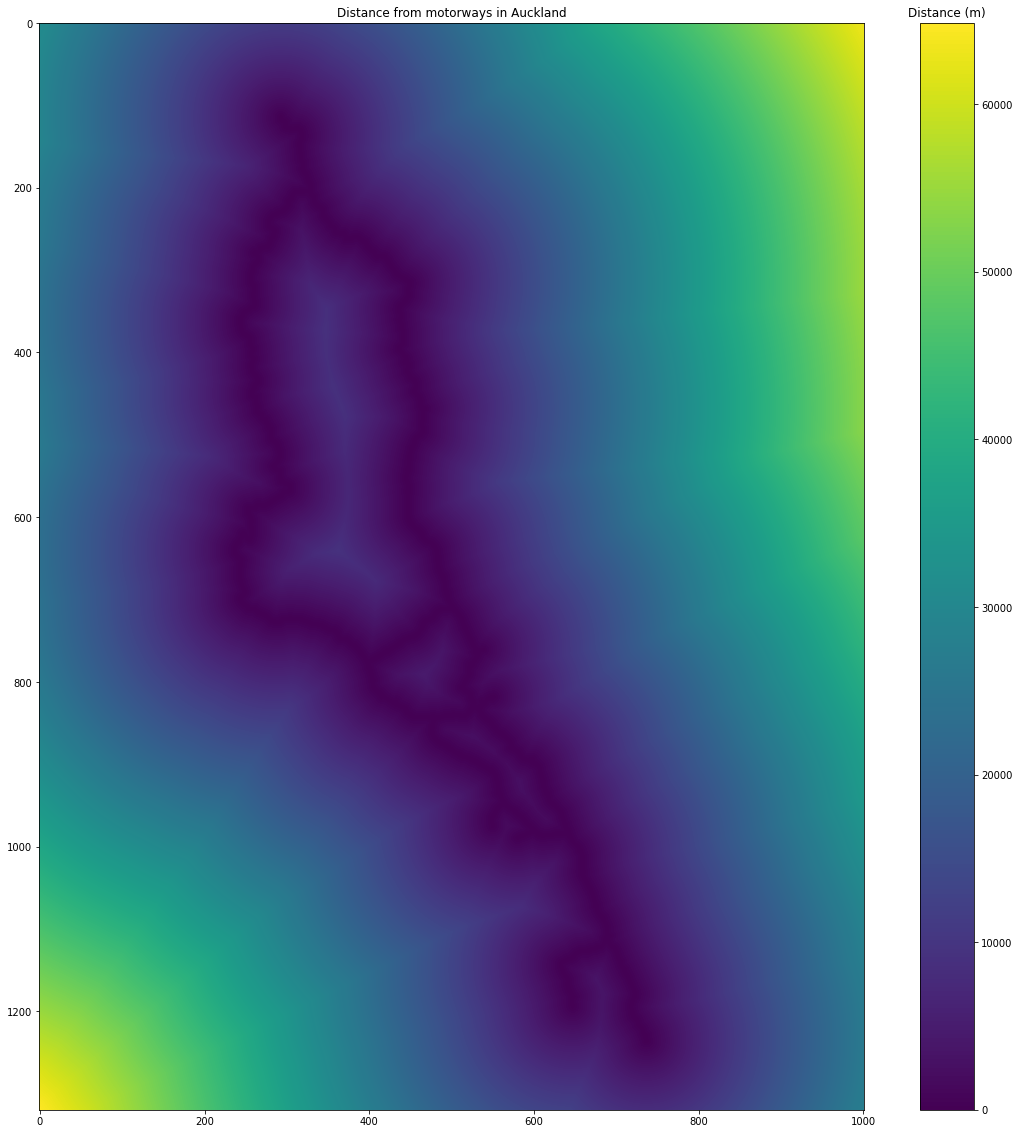

In [38]:
src_ds = gdal.Open("output/mway.tif")
srcband = src_ds.GetRasterBand(1)
dst_filename = "output/mway_dist.tif"
drv = gdal.GetDriverByName('GTiff')
dst_ds = drv.Create( dst_filename,
                     src_ds.RasterXSize, src_ds.RasterYSize, 1,
                     gdal.GetDataTypeByName('UInt16'))
dst_ds.SetGeoTransform( src_ds.GetGeoTransform() )
dst_ds.SetProjection( src_ds.GetProjectionRef() )
dstband = dst_ds.GetRasterBand(1)
prox = gdal.ComputeProximity(srcband,dstband,["DISTUNITS=GEO"]) # Encoded value is distance from motorway in meters
# Garbage collection of this variable flushes write
dst_ds = None
dst_ds = gdal.Open(dst_filename)
mway_dist = np.array(dst_ds.GetRasterBand(1).ReadAsArray())
print(mway_dist.shape)
plt.imshow(mway_dist)
plt.title("Distance from motorways in Auckland")
cb = plt.colorbar()
cb.ax.set_title("Distance (m)")

### Distance from CBD

(1320, 1001)
CPU times: user 310 ms, sys: 10 ms, total: 320 ms
Wall time: 318 ms


Text(0.5, 1.0, 'Distance (m)')

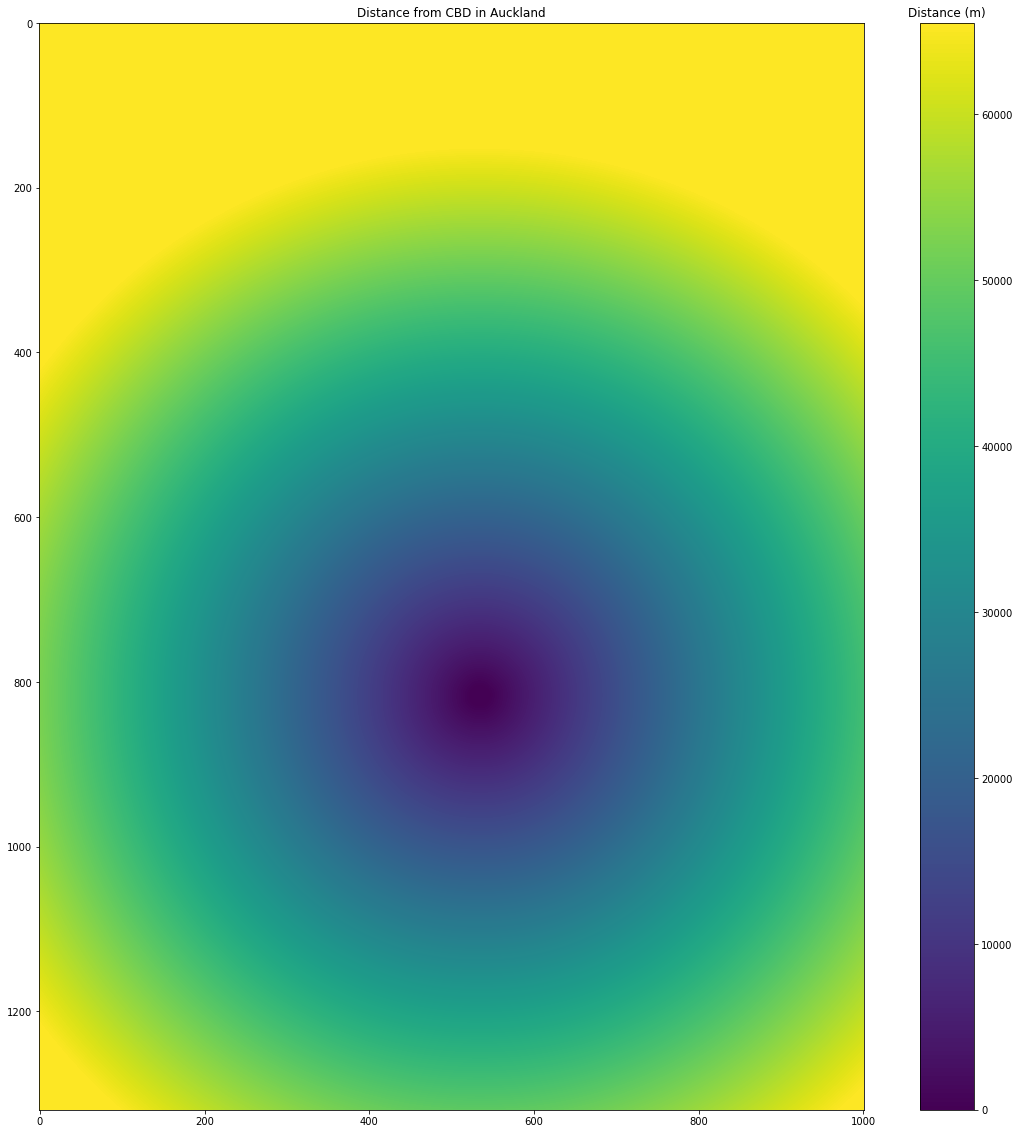

In [39]:
%%time
cbd = pop2018[pop2018.MB2020_V2_00 == "0433501"].copy()
cbd.geometry = cbd.geometry.buffer(1000)
cbd_cube = make_geocube(
    vector_data=cbd,
    like=geocube, # Ensures dimensions match
    fill=0
)
outfile = "output/cbd.tif"
cbd_cube.General_Electoral_Population.rio.to_raster(outfile, dtype=np.byte)
    
src_ds = gdal.Open("output/cbd.tif")
srcband = src_ds.GetRasterBand(1)
dst_filename = "output/cbd_dist.tif"
drv = gdal.GetDriverByName('GTiff')
dst_ds = drv.Create( dst_filename,
                     src_ds.RasterXSize, src_ds.RasterYSize, 1,
                     gdal.GetDataTypeByName('UInt16'))
dst_ds.SetGeoTransform( src_ds.GetGeoTransform() )
dst_ds.SetProjection( src_ds.GetProjectionRef() )
dstband = dst_ds.GetRasterBand(1)
prox = gdal.ComputeProximity(srcband,dstband,["DISTUNITS=GEO"]) # Encoded value is distance from motorway in meters
# Garbage collection of this variable flushes write
dst_ds = None
dst_ds = gdal.Open(dst_filename)
cbd_dist = np.array(dst_ds.GetRasterBand(1).ReadAsArray())
print(cbd_dist.shape)
plt.imshow(cbd_dist)
plt.title("Distance from CBD in Auckland")
cb = plt.colorbar()
cb.ax.set_title("Distance (m)")

# Slope

In [40]:
bounds = AKL.total_bounds.tolist()
bounds

[1703081.9789640256, 5870396.320936217, 1804839.668875325, 6002367.198185163]

In [41]:
zf = zipfile.ZipFile('input/lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip')
tiles = [file for file in zf.namelist() if file.endswith(".tif")]
tiles

['EJ.tif',
 'DM.tif',
 'EL.tif',
 'DL.tif',
 'DJ.tif',
 'FK.tif',
 'DK.tif',
 'EK.tif',
 'FL.tif']

In [49]:
tile_datasets = [rasterio.open(f'zip://input/lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip!{tile}') for tile in tiles]
DEM, transformation = rasterio.merge.merge(tile_datasets, bounds = bounds, res = (100,100))

In [50]:
cbd_dist.shape

(1320, 1001)

In [51]:
# Fix nodata
DEM[DEM == -32767] = np.nan
# Ensure same shape
DEM = DEM[:,0:cbd_dist.shape[0],0:cbd_dist.shape[1]]
DEM.shape

(1, 1320, 1001)

-30.0 78.27732 697.73083 (1, 1320, 1001)


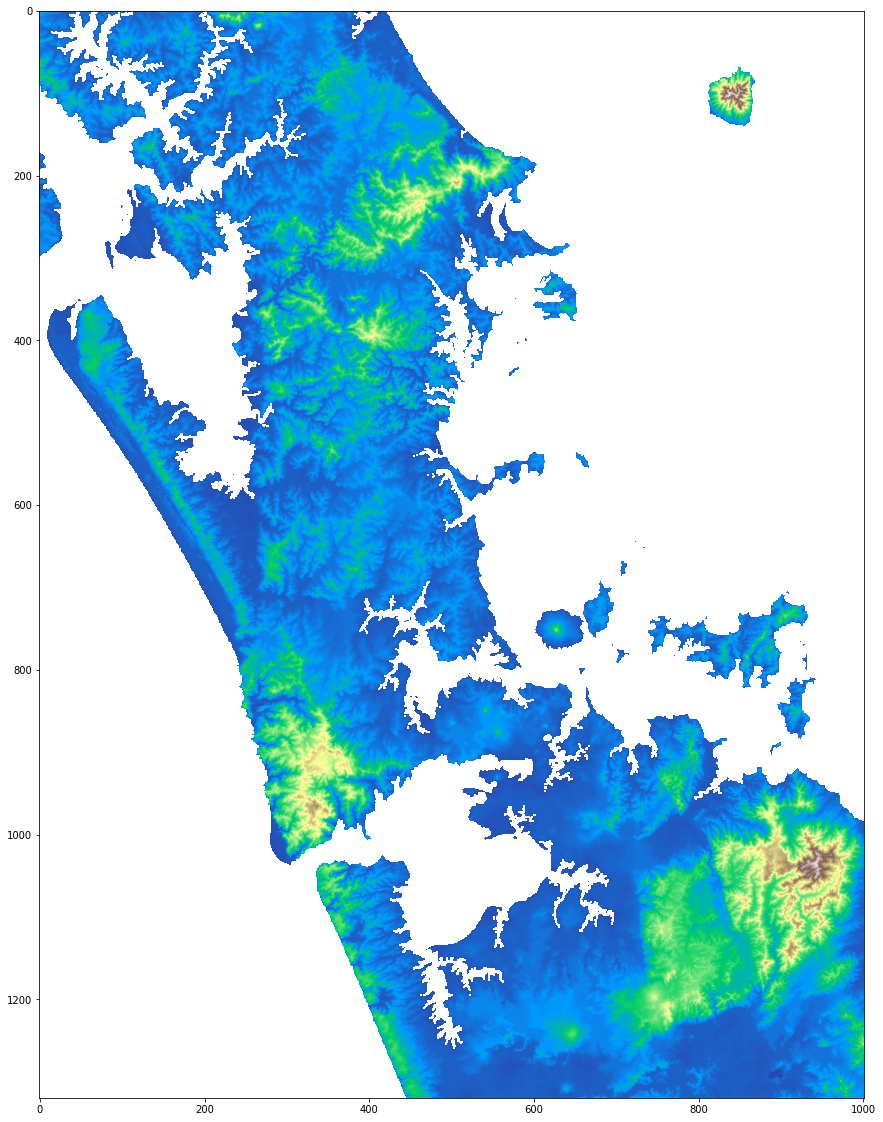

<AxesSubplot:>

In [52]:
print(np.nanmin(DEM), np.nanmean(DEM), np.nanmax(DEM), DEM.shape)
rasterio.plot.show(DEM, cmap='terrain')

In [58]:
meta = tile_datasets[0].meta
print(meta)
meta.update({
    "height": DEM.shape[1],
    "width": DEM.shape[2],
    "nodata": np.nan,
    "transform": transformation
})
print(meta)
outfile = "output/slope.tif"
if not os.path.isfile(outfile):
    with rasterio.open(outfile, "w", **meta) as dest:
       dest.write(DEM)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 3028, 'height': 8192, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(8.0, 0.0, 1679712.0,
       0.0, -8.0, 5963776.0)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1001, 'height': 1320, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(100.0, 0.0, 1703081.9789640256,
       0.0, -100.0, 6002367.198185163)}


In [55]:
!ls -Ggh output

total 113M
-rw-r--r-- 1 1.3M Apr 15 17:34 cbd.tif
-rw-r--r-- 1 2.6M Apr 15 17:34 cbd_dist.tif
-rw-r--r-- 1 1.3M Apr 15 14:25 land_use_1996.tif
-rw-r--r-- 1 1.3M Apr 15 14:25 land_use_2001.tif
-rw-r--r-- 1 1.3M Apr 15 14:25 land_use_2008.tif
-rw-r--r-- 1 1.3M Apr 15 14:25 land_use_2012.tif
-rw-r--r-- 1 1.3M Apr 15 14:25 land_use_2018.tif
-rw-r--r-- 1 1.3M Apr 15 14:37 mway.tif
-rw-r--r-- 1 2.6M Apr 15 17:34 mway_dist.tif
-rw-r--r-- 1 2.6M Apr 15 14:31 pop2013.tif
-rw-r--r-- 1 2.6M Apr 15 14:32 pop2018.tif
-rw-r--r-- 1  95M Apr 15 17:36 slope.tif
